# Прогнозирование изменения цены акций в краткосрочном периоде

# УСТАНОВКА APIMOEX И TALIB

In [1]:
import requests # ИНТЕРНЕТ (HTTP)
import os # РАБОТА С ОПЕРАЦИОННОЙ СИСТЕМОЙ

# УСТАНОВКА APIMOEX
try:
    import apimoex
except ImportError:
    os.system(f"pip install apimoex")
    
# УСТАНОВКА TALIB
python_version = "311" # ВАША ВЕРСИЯ ПИТОНА ВИДА NNN (ЕСЛИ ВЕРСИЯ 3.11, НАДО НАПИСАТЬ 311)
try:
    import talib
except ImportError:
    print("Библиотека talib не установлена. Начало установки")
    current_directory = os.getcwd()
    file_name = "TA_Lib-0.4.28-cp" + python_version + "-cp" + python_version + "-win_amd64.whl"
    url = 'https://github.com/cgohlke/talib-build/releases/download/v0.4.28/' + file_name
    response = requests.get(url)
    with open(file_name, 'wb') as f:
        f.write(response.content)
    os.system(f"pip install {file_name}")
    if os.path.exists(file_name):
        os.remove(file_name)

# ИМПОРТ БИБЛИОТЕК

In [2]:
import apimoex # МОСКОВСКАЯ БИРЖА
import mplfinance as mpf # ФИНАНСОВЫЕ ГРАФИКИ (СВЕЧИ) #pip install --upgrade mplfinance
import talib # БИБЛИОТЕКА ТЕХНИЧЕСКОГО АНАЛИЗА
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
warnings.filterwarnings("ignore")

# ПАРСИНГ СВЕЧЕЙ С МОСБИРЖИ

In [3]:
def get_candles(start_date: str, ticker: str, timeframe: int, filename: str) -> pd.DataFrame:
    """Функция для сохранения свечей выбранного инструмента с произвольной даты и указанного таймфрейма в файл csv
    
    Args:
        start_date (str): Начальная дата, с которой загружаются свечи. Вид: YYYY-MM-DD
        ticker (str): Тикер инструмента
        timeframe (int): Таймфрейм свечи (1 - 1M, 10 - 10M, 60 - 1H, 24 - 1D, 7 - 1W, 31 - 1 month, 4 - 1 quarter)
        filename (str): Имя csv файла, куда сохранить свечи
    """   
    with requests.Session() as session:
        if ticker == "IMOEX":
            data = apimoex.get_market_candles(session, "IMOEX", interval = timeframe, start = start_date, market = 'index')
        else:
            data = apimoex.get_market_candles(session, ticker, interval = timeframe, start = start_date)            
        candles = pd.DataFrame(data)
        candles.to_csv(filename + '.csv', index = False)
        first_candle_time = candles.iloc[1]['begin']
        last_candle_time = candles.iloc[-1]['begin']
        print(f'Время обновления: {datetime.now().replace(microsecond = 0)}')
        print(f'Количество свеч по {ticker}: {candles.shape[0]}')
        print(f'Время первой полученной свечи: {first_candle_time}')
        print(f'Время последней полученной свечи: {last_candle_time} \n')
     

In [4]:
#get_candles("2023-05-12", "SBER", 1, 'sber')
sber = pd.read_csv('sber.csv')
sber.head()

begin    open   close    high     low         value   volume
0  2023-05-12 09:59:00  231.00  231.00  231.00  231.00  1.608568e+08   696350
1  2023-05-12 10:00:00  231.05  232.38  232.47  230.52  6.528957e+08  2819200
2  2023-05-12 10:01:00  232.38  232.00  232.38  231.53  3.482892e+08  1501950
3  2023-05-12 10:02:00  231.90  232.10  232.38  231.61  2.798282e+08  1205930
4  2023-05-12 10:03:00  232.08  231.50  232.09  230.90  2.537112e+08  1095840

In [5]:
#get_candles("2023-05-12", "IMOEX", 1, 'imoex')
imoex = pd.read_csv('imoex.csv')
imoex.head()

begin     open    close     high      low         value  \
0  2023-05-12 10:00:00  2570.65  2580.41  2580.55  2570.65  1.111358e+09   
1  2023-05-12 10:01:00  2580.72  2582.12  2582.12  2579.61  6.206923e+08   
2  2023-05-12 10:02:00  2582.33  2584.59  2584.83  2581.75  6.074696e+08   
3  2023-05-12 10:03:00  2584.61  2580.18  2584.91  2579.25  5.306508e+08   
4  2023-05-12 10:04:00  2580.31  2579.21  2580.72  2579.21  2.135944e+08   

   volume  
0       0  
1       0  
2       0  
3       0  
4       0

# Предварительная обработка данных

In [6]:
# ПРИВОДИМ К НУЖНОМУ ВИДУ БАЗУ ДАННЫХ ПО ИНСТРУМЕНТУ
# ПОХОДУ VOLUME ИЗМЕРЯЕТСЯ В ТЫСЯЧАХ ЛОТОВ, ПРОВЕРИТЬ
def format_values(name: pd.DataFrame) -> pd.DataFrame:
    """Функция для обработки базы данных свечей. Приводит базу к нужному виду 

    Args:
        name (pd.DataFrame): DataFrame со свечами по инструменту

    Returns:
        pd.DataFrame: База данных, приведенная к нужному для анализа виду
    """       
    name.rename(columns = {'open':"Open", "close":"Close", "high":"High", "low":"Low", "volume":"Volume"}, inplace = True) # ПЕРЕИМЕНОВАЛИ ДЛЯ ГРАФИКА ЧЕРЕЗ MPF. ЕСЛИ НЕ ИСПОЛЬЗОВАТЬ, ТО НЕ НАДО
    name['begin'] = name['begin'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S')) # ПРЕОБРАЗОВЫВАЕМ СТРОКУ В ДАТУ
    name = name[(name['begin'].dt.strftime('%H:%M') < "18:40") & (name['begin'].dt.strftime('%H:%M') >= "10:00")] # ОСТАВЛЯЕМ ТОЛЬКО ДНЕВНУЮ СЕССИЮ
    name.set_index("begin", inplace = True) # СТАВИМ ДАТУ КАК ИНДЕКС
    return name

In [7]:
sber = format_values(sber)
sber.head()

Open   Close    High     Low         value   Volume
begin                                                                     
2023-05-12 10:00:00  231.05  232.38  232.47  230.52  6.528957e+08  2819200
2023-05-12 10:01:00  232.38  232.00  232.38  231.53  3.482892e+08  1501950
2023-05-12 10:02:00  231.90  232.10  232.38  231.61  2.798282e+08  1205930
2023-05-12 10:03:00  232.08  231.50  232.09  230.90  2.537112e+08  1095840
2023-05-12 10:04:00  231.50  231.81  231.83  231.47  9.480026e+07   409130

In [8]:
# РАСЧЕТЫ НА ОСНОВЕ ОСНОВНЫХ ПОКАЗАТЕЛЕЙ. ВРОДЕ БЫ ВЕЗДЕ ДОЛИ, НО МОЖНО И ПРОЦЕНТЫ (ПРОВЕРИТЬ ЧТОБЫ ВСЕ БЫЛО ОДНООБРАЗНО)
def get_candle_characteristics(name: pd.DataFrame) -> pd.DataFrame:
    """Функция для расчета основных характеристик свечи по ее параметрам

    Args:
        name (pd.DataFrame): База данных со свечами по инструменту

    Returns:
        pd.DataFrame: База данных с посчитанными характеристиками свечей
    """    
    name["body"] = abs(name['Close'] - name["Open"])/(name["High"] - name["Low"]) # ОТНОШЕНИЕ ТЕЛА СВЕЧИ КО ВСЕЙ СВЕЧЕ
    name['body'].fillna(0, inplace = True) # ГДЕ HIGH = LOW ПИШЕМ 0
    name['colour'] = name.apply(lambda row: "green" if row['Close'] >= row["Open"] else "red", axis = 1) # КОДИРУЕМ ЦВЕТ СВЕЧИ
    name['weekday'] = name.index.day_name()
    #name['session'] = name.apply(lambda row: 'main' if row.name.time() < datetime.strptime('19:00', '%H:%M').time() else 'evening', axis = 1) # ТОРГОВАЯ СЕССИЯ
    name['change'] = (name['Close']- name['Open'])/name['Open'] # ИЗМЕНЕНИЕ ЦЕНЫ ЗА МИНУТУ
    name['span_up'] = name.apply(lambda row: (row['High'] - row['Open'])/row['Open'] if row["Open"] >= row['Close'] else (row['High'] - row['Close'])/row['Close'] , axis = 1) # ОТКЛОНЕНИЕ НАВЕРХ (ТЕНЬ)
    name['span_down'] = name.apply(lambda row: (row['Close'] - row['Low'])/row['Close'] if row["Open"] >= row['Close'] else (row['Open'] - row['Low'])/row['Open'] , axis = 1) # ОТКЛОНЕНИЕ ВНИЗ (ТЕНЬ)
    return name

In [9]:
sber = get_candle_characteristics(sber)
sber.head()

Open   Close    High     Low         value   Volume  \
begin                                                                        
2023-05-12 10:00:00  231.05  232.38  232.47  230.52  6.528957e+08  2819200   
2023-05-12 10:01:00  232.38  232.00  232.38  231.53  3.482892e+08  1501950   
2023-05-12 10:02:00  231.90  232.10  232.38  231.61  2.798282e+08  1205930   
2023-05-12 10:03:00  232.08  231.50  232.09  230.90  2.537112e+08  1095840   
2023-05-12 10:04:00  231.50  231.81  231.83  231.47  9.480026e+07   409130   

                         body colour weekday    change   span_up  span_down  
begin                                                                        
2023-05-12 10:00:00  0.682051  green  Friday  0.005756  0.000387   0.002294  
2023-05-12 10:01:00  0.447059    red  Friday -0.001635  0.000000   0.002026  
2023-05-12 10:02:00  0.259740  green  Friday  0.000862  0.001206   0.001251  
2023-05-12 10:03:00  0.487395    red  Friday -0.002499  0.000043   0.002592  
2023-05-12 10:04:00  0.861111  green  Friday  0.001339  0.000086   0.000130

In [10]:
def get_TA(name: pd.DataFrame, n: int) -> pd.DataFrame:
    """Функция для расчета значений индикаторов технического анализа 

    Args:
        name (pd.DataFrame): База данных со свечами по инструменту
        n (int): Количество первых свечей для удаления (чтобы не было NaN у индикаторов и все они были посчитаны)

    Returns:
        pd.DataFrame: База данных с посчитанными значениями индикаторов
    """    
    name["rsi"] = talib.RSI(name['Close'], timeperiod = 14) # RSI
    macd, macdsignal, name['macdhist'] = talib.MACD(name['Close'], fastperiod = 12, slowperiod = 26, signalperiod = 9) # MACD
    name['slowk'], name['slowd'] = talib.STOCH(name['High'], name['Low'], name['Close'], fastk_period = 14, slowk_period = 1, slowk_matype = 0, slowd_period = 3, slowd_matype = 0) # STOCHASTIC
    name['adx'] = talib.ADX(name['High'], name['Low'], name['Close'], timeperiod = 14) #ADX
    name['atr'] = talib.ATR(name['High'], name['Low'], name['Close'], timeperiod = 14) #ATR
    name = name[n:]  # УДАЛЯЕМ ПЕРВЫЕ СТРОКИ ЧТОБЫ У ИНДИКАТОРОВ НЕ БЫЛО NaN. ПОДКОРРЕКТИРОВАТЬ В ЗАВИСИМОСТИ ОТ ПЕРИОДОВ ИНДИКАТОРОВ
    return name

In [11]:
sber = get_TA(sber, 33)
sber.head()

Open   Close    High     Low       value  Volume  \
begin                                                                     
2023-05-12 10:33:00  228.84  228.80  228.85  228.72  24568100.0  107390   
2023-05-12 10:34:00  228.77  228.93  229.18  228.73  42463547.5  185470   
2023-05-12 10:35:00  228.93  228.94  229.20  228.90  29699548.2  129650   
2023-05-12 10:36:00  228.94  228.86  229.00  228.50  32019311.9  139970   
2023-05-12 10:37:00  228.87  228.89  228.97  228.80  31303742.0  136780   

                         body colour weekday    change   span_up  span_down  \
begin                                                                         
2023-05-12 10:33:00  0.307692    red  Friday -0.000175  0.000044   0.000350   
2023-05-12 10:34:00  0.355556  green  Friday  0.000699  0.001092   0.000175   
2023-05-12 10:35:00  0.033333  green  Friday  0.000044  0.001136   0.000131   
2023-05-12 10:36:00  0.160000    red  Friday -0.000349  0.000262   0.001573   
2023-05-12 10:37:00  0.117647  green  Friday  0.000087  0.000350   0.000306   

                           rsi  macdhist      slowk      slowd        adx  \
begin                                                                       
2023-05-12 10:33:00  33.460241  0.003114  24.576271  20.762712  50.839494   
2023-05-12 10:34:00  35.691689  0.021696  30.084746  26.836158  50.130020   
2023-05-12 10:35:00  35.869849  0.038071  32.000000  28.887006  49.411119   
2023-05-12 10:36:00  35.033664  0.046375  29.090909  30.391885  49.231451   
2023-05-12 10:37:00  35.639573  0.056098  37.640449  32.910453  49.064617   

                          atr  
begin                          
2023-05-12 10:33:00  0.493549  
2023-05-12 10:34:00  0.490438  
2023-05-12 10:35:00  0.476836  
2023-05-12 10:36:00  0.478490  
2023-05-12 10:37:00  0.456455

In [12]:
# СВЕЧНЫЕ ПАТТЕРНЫ
def get_candle_patterns(name: pd.DataFrame) -> pd.DataFrame:
    """Функция для распознования свечных паттернов

    Args:
        name (pd.DataFrame): База данных со свечами по инструменту

    Returns:
        pd.DataFrame: База данных со свечными паттернами
    """    
    name['engulfing'] = talib.CDLENGULFING(name['Open'], name['High'], name['Low'], name['Close'])/100  # ENGULFING CANDLE
    name['doji'] = talib.CDLDOJI(name['Open'], name['High'], name['Low'], name['Close'])/100  # DOJI CANDLE
    name['hammer'] = talib.CDLHAMMER(name['Open'], name['High'], name['Low'], name['Close'])/100  # HAMMER CANDLE
    name['inv_hammer'] = talib.CDLINVERTEDHAMMER(name['Open'], name['High'], name['Low'], name['Close'])/100  # INVERTED HAMMER CANDLE
    name['shooting_star'] = talib.CDLSHOOTINGSTAR(name['Open'], name['High'], name['Low'], name['Close'])/100  # SHOOTING STAR CANDLE
    name['marubuzu'] = talib.CDLMARUBOZU(name['Open'], name['High'], name['Low'], name['Close'])/100  # MARUBOZU STAR CANDLE
    return name

In [13]:
sber = get_candle_patterns(sber)
sber.head()

Open   Close    High     Low       value  Volume  \
begin                                                                     
2023-05-12 10:33:00  228.84  228.80  228.85  228.72  24568100.0  107390   
2023-05-12 10:34:00  228.77  228.93  229.18  228.73  42463547.5  185470   
2023-05-12 10:35:00  228.93  228.94  229.20  228.90  29699548.2  129650   
2023-05-12 10:36:00  228.94  228.86  229.00  228.50  32019311.9  139970   
2023-05-12 10:37:00  228.87  228.89  228.97  228.80  31303742.0  136780   

                         body colour weekday    change  ...      slowk  \
begin                                                   ...              
2023-05-12 10:33:00  0.307692    red  Friday -0.000175  ...  24.576271   
2023-05-12 10:34:00  0.355556  green  Friday  0.000699  ...  30.084746   
2023-05-12 10:35:00  0.033333  green  Friday  0.000044  ...  32.000000   
2023-05-12 10:36:00  0.160000    red  Friday -0.000349  ...  29.090909   
2023-05-12 10:37:00  0.117647  green  Friday  0.000087  ...  37.640449   

                         slowd        adx       atr  engulfing  doji  hammer  \
begin                                                                          
2023-05-12 10:33:00  20.762712  50.839494  0.493549        0.0   0.0     0.0   
2023-05-12 10:34:00  26.836158  50.130020  0.490438        0.0   0.0     0.0   
2023-05-12 10:35:00  28.887006  49.411119  0.476836        0.0   0.0     0.0   
2023-05-12 10:36:00  30.391885  49.231451  0.478490        0.0   0.0     0.0   
2023-05-12 10:37:00  32.910453  49.064617  0.456455        0.0   0.0     0.0   

                     inv_hammer  shooting_star  marubuzu  
begin                                                     
2023-05-12 10:33:00         0.0            0.0       0.0  
2023-05-12 10:34:00         0.0            0.0       0.0  
2023-05-12 10:35:00         0.0            0.0       0.0  
2023-05-12 10:36:00         0.0            0.0       0.0  
2023-05-12 10:37:00         0.0            0.0       0.0  

[5 rows x 24 columns]

In [14]:
def get_target_answers(name: pd.DataFrame) -> tuple: 
    """Функция, возвращающая цвет следующей свечи и записывающая его в базу данных со свечами по инструменту

    Args:
        name (pd.DataFrame): База данных со свечами по инструменту

    Returns:
        tuple: Кортеж, содержащий DataFrame с обновленными данными и массив с правильными ответами (цвет следующей свечи)
    """       
    y = name["change_all"][1:].values # ПОЛУЧАЕМ ВСЕ СВЕЧИ КРОМЕ ПЕРВОЙ
    name = name[:-1] # УДАЛЯЕМ ПОСЛЕДНЮЮ СТРОКУ, ДЛЯ НЕЕ НЕТ ПРОГНОЗА
    name['target'] = y # ЗАПИСЫВАЕМ ОТВЕТЫ
    return name, y

In [16]:
#sber, sber_y = get_target_answers(sber)
print(sber.shape)
sber.head()

(132402, 24)


Index(['Open', 'Close', 'High', 'Low', 'value', 'Volume', 'body', 'colour',
       'weekday', 'change', 'span_up', 'span_down', 'rsi', 'macdhist', 'slowk',
       'slowd', 'adx', 'atr', 'engulfing', 'doji', 'hammer', 'inv_hammer',
       'shooting_star', 'marubuzu'],
      dtype='object')

In [15]:
#ВСЕ ФУНКЦИИ В ОДНОМ МЕСТЕ
#get_candles("2023-05-12", "LKOH", 1, 'lkoh')
lukoil = pd.read_csv('lkoh.csv')
lukoil = format_values(lukoil)
lukoil = get_candle_characteristics(lukoil)
lukoil = get_TA(lukoil, 33)
lukoil = get_candle_patterns(lukoil)
#lukoil, lukoil_y = get_target_answers(lukoil)
print(lukoil.shape)
lukoil.tail()

(132402, 24)


Open   Close    High     Low      value  Volume  body  \
begin                                                                          
2024-05-10 18:35:00  7716.5  7716.5  7717.0  7716.5  2924625.5     379   0.0   
2024-05-10 18:36:00  7717.0  7716.0  7717.0  7716.0  1010859.5     131   1.0   
2024-05-10 18:37:00  7716.0  7716.5  7716.5  7716.0   810205.0     105   1.0   
2024-05-10 18:38:00  7716.5  7716.0  7716.5  7716.0  6311751.5     818   1.0   
2024-05-10 18:39:00  7716.0  7716.5  7716.5  7716.0  2276222.0     295   1.0   

                    colour weekday    change  ...      slowk         slowd  \
begin                                         ...                            
2024-05-10 18:35:00  green  Friday  0.000000  ...   0.000000  5.555556e+00   
2024-05-10 18:36:00    red  Friday -0.000130  ...   0.000000 -5.750659e-12   
2024-05-10 18:37:00  green  Friday  0.000065  ...  16.666667  5.555556e+00   
2024-05-10 18:38:00    red  Friday -0.000065  ...   0.000000  5.555556e+00   
2024-05-10 18:39:00  green  Friday  0.000065  ...  20.000000  1.222222e+01   

                           adx       atr  engulfing  doji  hammer  inv_hammer  \
begin                                                                           
2024-05-10 18:35:00  23.470194  0.852063        0.0   1.0     0.0         0.0   
2024-05-10 18:36:00  25.671563  0.862630       -1.0   0.0     0.0         0.0   
2024-05-10 18:37:00  27.715691  0.836727        0.0   0.0     0.0         0.0   
2024-05-10 18:38:00  29.613811  0.812676        0.0   0.0     0.0         0.0   
2024-05-10 18:39:00  31.376350  0.790342        0.0   0.0     0.0         0.0   

                     shooting_star  marubuzu  
begin                                         
2024-05-10 18:35:00            0.0       0.0  
2024-05-10 18:36:00            0.0      -1.0  
2024-05-10 18:37:00            0.0       1.0  
2024-05-10 18:38:00            0.0      -1.0  
2024-05-10 18:39:00            0.0       1.0  

[5 rows x 24 columns]

# Описание признаков
**"Японские свечи"** - это наиболее информативная форма графика, применяемая в техническом анализе изменения цен финансовых инструментов. Свеча показывает изменение стоимости актива за определённый промежуток времени, а также минимумы и максимумы цены за данный промежуток.
* **Open** - цена открытия свечи, то есть цена инструмента на начало определённого временного промежутка.
* **Close** - цена закрытия свечи, то есть цена инструмента на конец определённого временного промежутка.
* **High** - максимальная цена инструмента, которую он достиг за определённый промежуток(за соответствующую свечу).
* **Low** - минимальная цена инструмента, до которой он падал за определённый промежуток(за соответствующую свечу).
* **value** - объём торгов по инструменту в деньгах за определённый временной промежуток.
* **Volume** - объём торгов в лотах. Лот на финансовом рынке — это единица измерения пакета ценных бумаг (или других финансовых инструментов) при совершении сделки. Иными словами, лот — минимальное количество актива, которое можно купить или продать. Один лот может содержат в себе 1, 10, 1 000, 10 000, 100 000 и т.д ценных бумаг.
* **body** - отношения тела свечи (разницы между open и close) ко всей свече (разницы high и low)
* **colour** - цвет свечи в зависимости от динамики цены за временной промежуток. Если цена открытия выше цены закрытия, то цена актива упала за данный промежуток (красная свеча). Если цена закрытия выше цены открытия свечи, то цена актива выросла за этот промежуток (зеленая свеча).
* **session** - торговая сессия. У финансовых инструментов есть 3 торговые сессии: утренняя, дневная и вечерняя. У акций есть только дневная (main) и вечерняя (evening) торговые сессии.
* **change** - относительное изменение цены инструмента за промежуток времени.
* **span_up** - верхняя тень свечи, которая указывает на отклонение цены актива вверх относительно тела свечи.
* **span_down** - нижняя тень свечи, которая указывает на отклонение цены актива вниз относительно тела свечи.


Графическое изображение японской свечи:

<p align="center">
<a href="https://ibb.co/Xb2GVJj"><img src="https://i.ibb.co/rm7XvyF/image.png" alt="image" border="0"></a>
</p>

**Технический анализ** - это метод анализа финансовых рынков, основанный на изучении и интерпретации прошлых данных о ценах, объемах и других рыночных параметрах с целью прогнозирования будущих ценовых движений. Он используется в инвестиционной деятельности для принятия решений о покупке, продаже или удержании активов. Технический анализ основан на предположении, что рыночные цены отражают все доступные информационные данные и тенденции, и что исторические ценовые данные могут быть использованы для прогнозирования будущих ценовых движений.
* **RSI (Relative Strength Index)** - это технический индикатор, который используется для оценки перекупленности или перепроданности рынка. Он выражается числом от 0 до 100 и помогает трейдерам определить возможные точки разворота ценовых движений. RSI выше 70 обычно указывает на перекупленность рынка, а RSI ниже 30 - на перепроданность.
* **macdhist (Гистограмма MACD)** - это разница между MACD и сигнальной линией MACD. Гистограмма отображает относительное расположение MACD относительно сигнальной линии. Положительные значения указывают на увеличение мощности тренда, а отрицательные - на его ослабление.
* **slowk (Стохастический осциллятор)** - процентное отношение текущей цены закрытия к диапазону цен за определенный период времени. Он измеряет скорость и направление изменения цены закрытия актива относительно диапазона цен за определенный период. 
* **SlowD (Стохастический осциллятор) - это скользящее среднее SlowK за 3 периода. Оно помогает сгладить колебания SlowK и предоставить более плавные сигналы.**
* **ADX (Average Directional Index)** - это технический индикатор, который используется для измерения силы и направления тренда на рынке. Он основан на двух других индикаторах - плюсовом и минусовом направленных движениях (+DI и -DI). ADX выражается числом от 0 до 100 и позволяет трейдерам определить, насколько сильным является текущий тренд на рынке.
* **ATR (Average True Range)** - это технический индикатор, который используется для измерения волатильности рынка. Он представляет собой среднее значение наибольшего из трех следующих величин: разницы между текущим максимумом и текущим минимумом, разницы между предыдущим закрытием и текущим максимумом, разницы между предыдущим закрытием и текущим минимумом. ATR помогает трейдерам оценить ожидаемую волатильность на рынке и принимать решения о размере стоп-лоссов и целей прибыли.

**Свечные паттерны** - это графические образования на графиках ценных бумаг или других активов, представленные в виде свечей. Свечные паттерны могут указывать на возможные направления ценового движения на рынке: некоторые предсказывают рост цен (бычьи паттерны), другие - падение (медвежьи паттерны). Трейдеры используют их для принятия торговых решений (возможные развороты, сила тренда и т.д.)

* **Engulfing** - "поглощение", свечной паттерн, который сформирован из двух свечей.

**engulfing=1** - "бычье поглощение", первая свеча представляет собой короткое красное тело, которое полностью поглощено более крупной зеленой свечой.

<p align="center">
<a href="https://imgbb.com/"><img src="https://i.ibb.co/34yDNxb/image.png" alt="image" border="0"></a>
</p>

**engulfing=-1**- "медвежье поглощение", первая свеча имеет маленькое зеленое тело, которое поглощается последующей длинной красной свечой.

<p align="center">
<a href="https://imgbb.com/"><img src="https://i.ibb.co/N7nc2zm/image.png" alt="image" border="0"></a>
</p>

* **Doji** - это один из основных свечных паттернов, который характеризуется тем, что цена открытия и цена закрытия находятся примерно на одном уровне. В результате свеча выглядит как короткая вертикальная линия с телом, которое очень близко к точке открытия и закрытия. Этот паттерн часто свидетельствует о том, что рынок находится в состоянии равновесия между медведями (продавцами) и быками (покупателями), и может предшествовать развороту тренда.

<p align="center">
<a href="https://imgbb.com/"><img src="https://i.ibb.co/c2pw39t/image.png" alt="image" border="0"></a>
</p>

* **hammer** - это свечной паттерн, который часто встречается на графиках ценовой динамики и сигнализирует о возможном развороте тренда. Он состоит из короткого тела свечи с длинной нижней тенью (линией), которая указывает на то, что цена сначала снижалась, но затем вернулась выше, к цене открытия. Это может свидетельствовать о том, что сила продавцов ослабла, и рынок может начать рост.

<p align="center">
<a href="https://imgbb.com/"><img src="https://brokerreview.net/images/uploads/2020/10/12/hammer-patterns.png" alt="image" border="0"></a>
</p>

**hammer=1** - "бычий молот". Эта свеча образуется, когда продавцы намереваются снизить цену, но на рынок входят покупатели (быки) и не позволяют цене снизиться, и в итоге цена закрытия свечи фиксируется выше цены открытия.

**hammer=-1** - "медвежий молот". Эта свеча образуется, когда покупатели намереваются повысить цену, но на рынок входят продавцы (медведи) и не позволяют цене вырасти, и в итоге цена закрытия свечи фиксируется ниже цены открытия.

<p align="center">
<a href="https://imgbb.com/"><img src="https://i.ibb.co/rxSbL7x/image.png" alt="image" border="0"></a>
</p>

* **invhammer** - "Invhammer" (обратный молот). Этот паттерн имеет форму, противоположную молоту. Он также состоит из короткого тела свечи, но с длинной верхней тенью. Это может указывать на то, что цены сначала повышались, но затем были отброшены ниже, к цене открытия, что может быть сигналом о возможном развороте восходящего тренда вниз.

<p align="center">
<a href="https://imgbb.com/"><img src="https://i.ibb.co/JrTKRTr/image.png" alt="image" border="0"></a>
</p>

* **shooting_star** - "shooting star" - это свечной паттерн, который похож на инвертированный молот, но выстраивается после восходящего рынка, предвещая нисходящий тренд. 

<p align="center">
<a href="https://imgbb.com/"><img src="https://static-app.bb-os.com/activity/Screenshot%202023-10-05%20at%204.50.57%20AM-min-1696452760661.png" alt="image" border="0"></a>
</p>

* **marubuzu** - это длинная свеча без верхней и нижней тени. Марубозу может быть, как медвежий, так и бычий.

**marubuzu=1** Для бычьего сигнала открытие и минимум по одной цене, а закрытие и максимум по другой цене.

**marubuzu=-1** Для медвежьего сигнала все наоборот. Цена открытия и максимум одинаковы, цена закрытия и минимум тоже одинаковы.

<p align="center">
<a href="https://ibb.co/dPxnMxz"><img src="https://i.ibb.co/CbDx8DT/image.png" alt="image" border="0"></a><br />
</p>

# EDA, изучение данных

In [39]:
sber1 = sber.drop(columns =  ["High", "Low"])
X = pd.concat([sber1.shift(i).add_suffix(str(i)) for i in range(4)], axis=1).dropna() # ТАБЛИЦА С ОБЪЕКТАМИ ИЗ 4 СВЕЧ

In [40]:
X['change_all'] = X['Close0']/X['Open3'] - 1 # ИЗМЕНЕНИЕ ЗА 4 СВЕЧИ

In [41]:
X.drop(columns = ['Open0', 'Open1', 'Open2', 'Open3', 'Close0', 'Close1', 'Close2', 'Close3'], inplace = True)
#Open0 - последняя свеча, Open1 (период t-1), Open2 (период t-2), Open3 (период t-3) - это открытие свеч, предшествующих Open0

In [42]:
X, X_y = get_target_answers(X) # ПОЛУЧАЕМ ЗНАЧЕНИЕ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ


In [43]:
X['trend'] = X.apply(lambda row: 1 if row['change_all'] >= 0 else 0, axis = 1) # КОДИРУЕМ ИЗМЕНЕНИЕ ЗА 4 СВЕЧИ (упало/выросло)
X['target_trend'] = X.apply(lambda row: 1 if row['target'] >= 0 else 0, axis = 1) # КОДИРУЕМ ИЗМЕНЕНИЕ ЗА 4 СВЕЧИ (упало/выросло)

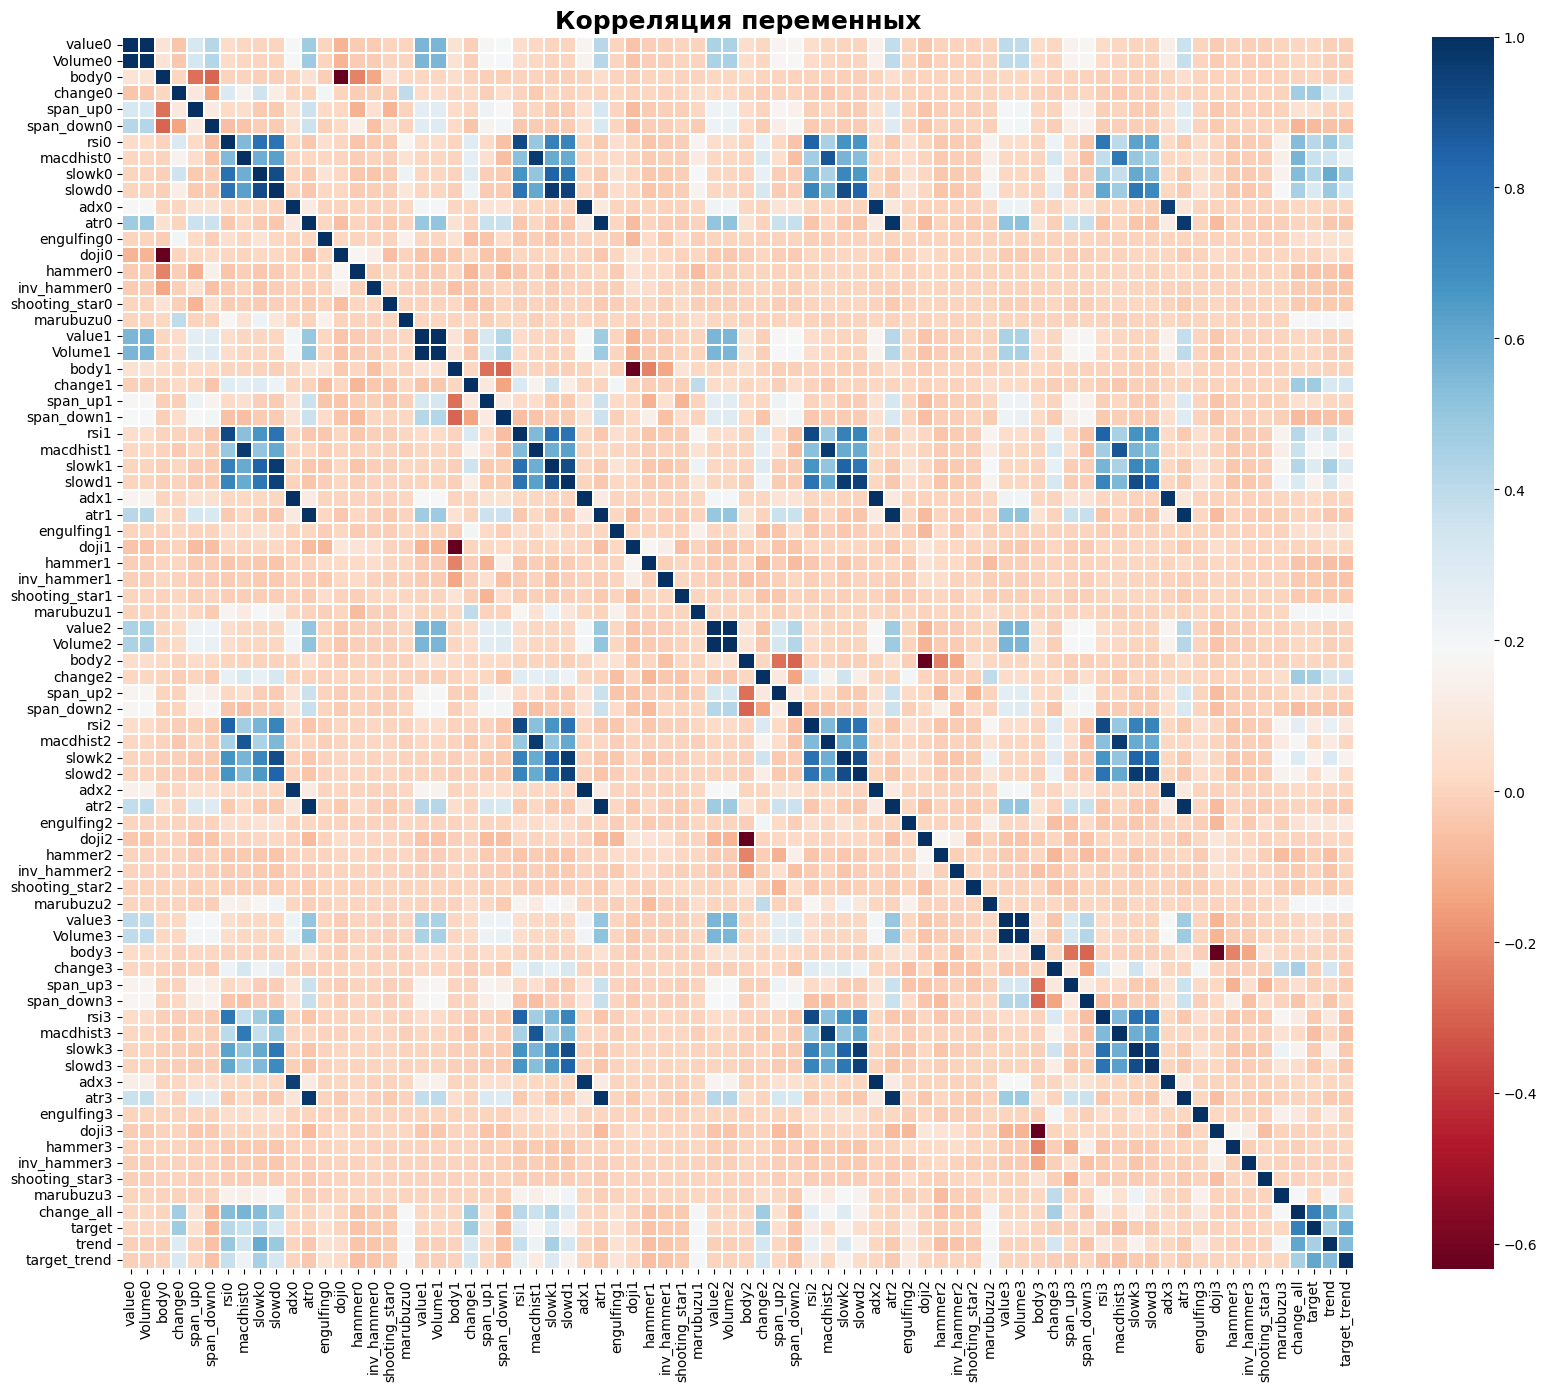

In [44]:
plt.figure(figsize= (20,16))
sns.heatmap(X.corr(method='pearson', numeric_only=True), 
           square=True, fmt=".1f", 
          linewidths=0.1, cmap="RdBu")
plt.title("Корреляция переменных", fontsize = 18, fontweight = 'bold');

In [48]:
X.describe()

value0       Volume0          body0       change0       span_up0  \
count  1.323980e+05  1.323980e+05  132398.000000  1.323980e+05  132398.000000   
mean   1.682043e+07  6.286942e+04       0.539292  1.311719e-07       0.000082   
std    3.306205e+07  1.232390e+05       0.328512  4.463240e-04       0.000149   
min    8.202000e+03  3.000000e+01       0.000000 -1.337049e-02       0.000000   
25%    3.361281e+06  1.239000e+04       0.250000 -1.476928e-04       0.000000   
50%    7.487334e+06  2.776000e+04       0.555556  0.000000e+00       0.000036   
75%    1.745607e+07  6.511000e+04       0.833333  1.489938e-04       0.000108   
max    2.500455e+09  8.002170e+06       1.000000  1.006815e-02       0.008310   

          span_down0           rsi0      macdhist0         slowk0  \
count  132398.000000  132398.000000  132398.000000  132398.000000   
mean        0.000099      50.661885       0.000016      52.429597   
std         0.000167      12.482556       0.041654      32.012187   
min         0.000000       2.101046      -0.545911       0.000000   
25%         0.000000      42.327797      -0.018371      23.913043   
50%         0.000039      50.408609      -0.000390      53.125000   
75%         0.000124      58.657326       0.017630      81.818182   
max         0.008286      98.780211       0.605410     100.000000   

             slowd0  ...     engulfing3          doji3        hammer3  \
count  1.323980e+05  ...  132398.000000  132398.000000  132398.000000   
mean   5.242938e+01  ...      -0.006820       0.176007       0.042297   
std    2.979970e+01  ...       0.187465       0.380828       0.201266   
min   -4.642213e-13  ...      -1.000000       0.000000       0.000000   
25%    2.554491e+01  ...       0.000000       0.000000       0.000000   
50%    5.306707e+01  ...       0.000000       0.000000       0.000000   
75%    7.987132e+01  ...       0.000000       0.000000       0.000000   
max    1.000000e+02  ...       1.000000       1.000000       1.000000   

         inv_hammer3  shooting_star3      marubuzu3     change_all  \
count  132398.000000   132398.000000  132398.000000  132398.000000   
mean        0.011299       -0.004947       0.004343       0.000008   
std         0.105696        0.070162       0.319965       0.000956   
min         0.000000       -1.000000      -1.000000      -0.017957   
25%         0.000000        0.000000       0.000000      -0.000364   
50%         0.000000        0.000000       0.000000       0.000000   
75%         0.000000        0.000000       0.000000       0.000367   
max         1.000000        0.000000       1.000000       0.022133   

              target          trend   target_trend  
count  132398.000000  132398.000000  132398.000000  
mean        0.000008       0.523648       0.523648  
std         0.000956       0.499442       0.499442  
min        -0.017957       0.000000       0.000000  
25%        -0.000364       0.000000       0.000000  
50%         0.000000       1.000000       1.000000  
75%         0.000367       1.000000       1.000000  
max         0.022133       1.000000       1.000000  

[8 rows x 76 columns]

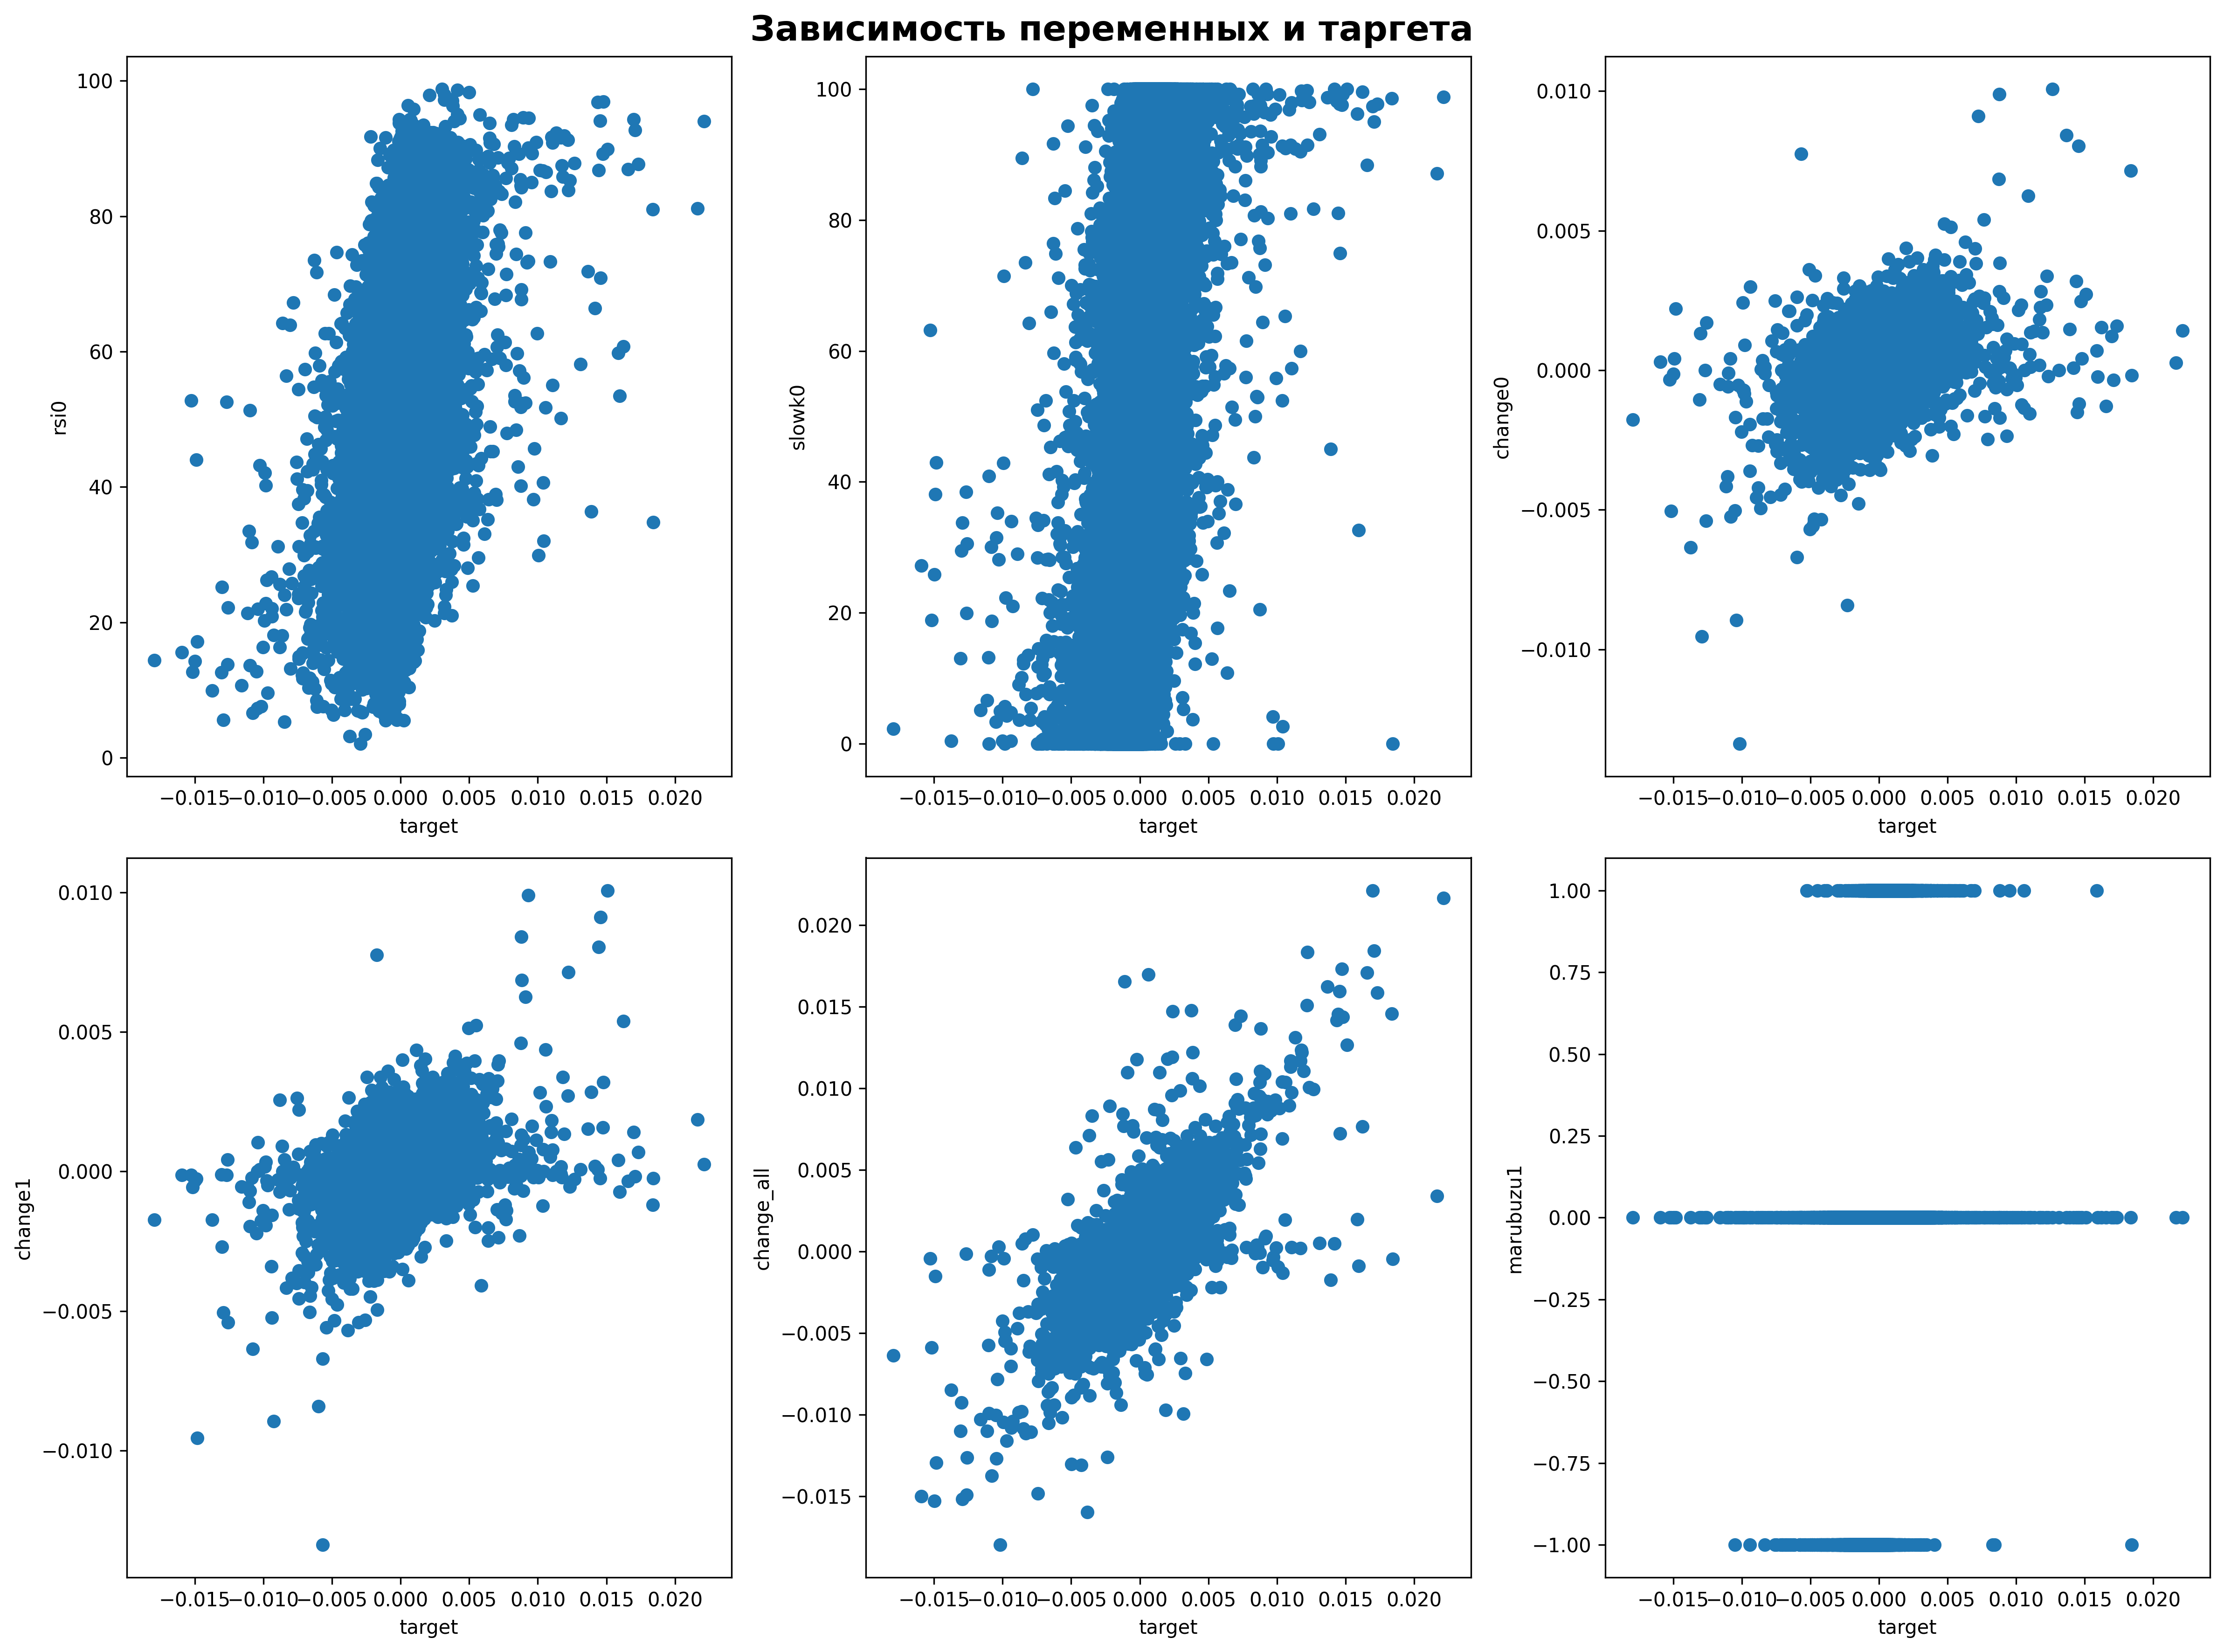

In [49]:
fig, axs = plt.subplots(2, 3, figsize=(16, 12), dpi=300)

var = ['rsi0', 'slowk0', 'change0', 'change1', 'change_all', 'marubuzu1']

for i, var in enumerate(var):
    row = i // 3
    col = i % 3 
    axs[row, col].scatter(X['target'], X[var]) 
    axs[row, col].set_xlabel("target")  
    axs[row, col].set_ylabel(var)  
    

fig.suptitle('Зависимость переменных и таргета', fontsize = 18, fontweight = 'bold')
plt.tight_layout()  
plt.show()  

# Какие выводы можно сделать из данных зависимостей:
1) Существует прямая зависимость между изменением стоимости бумаги и значением RSI последней свечи. Чем больше RSI, тем больше и процентное изменение свеч в будущем. 
2) Аналогичные выводы можно сделать исходя из значений стохастического осциллятора. Чем больше значение slowk0, тем больше изменение стоимости ценной бумаги в краткосрочном периоде. Тоже прямая взаимосвязь. Однако наклон чуть более крутой чем на графике зависимости между RSI и целевой переменной.
3) Исходя из третьего графика, можно сделать вывод о том, что текущее изменение цены прямо влияет на изменение цены в ближайшем будущем, что в целом логично. Однако заметно, что есть много рассеиваний и выбросов.
4) Также можно сделать вывод о том, что значение предпоследней свечи также влияет на краткосрочное изменение, что показывает отложенный эффект.
5) Исходя из 5 графика, можно сделать вывод, что если несколько свечей подряд был рост, то цена в краткосрочном периоде скорее будет расти, чем падать. Тут гораздо меньше выбросов, данные менее рассеяны. Это говорит о том, что совокупное изменение нескольких свечей лучше предсказывает ближайшее изменение цены, чем просто 1 свеча. 
6) На 6 графике видно, что графический паттерн marubozu позволяет понять, в какую сторону скорее всего будет движение цены бумаги. Если марубозу отрицательный (медвежий), то инструмент склонен падать, в то время как если положительная - склонен расти. Также можно заметить, что marubozu - редкий графический паттерн, много значений равно 0.

(-0.005, 0.005)

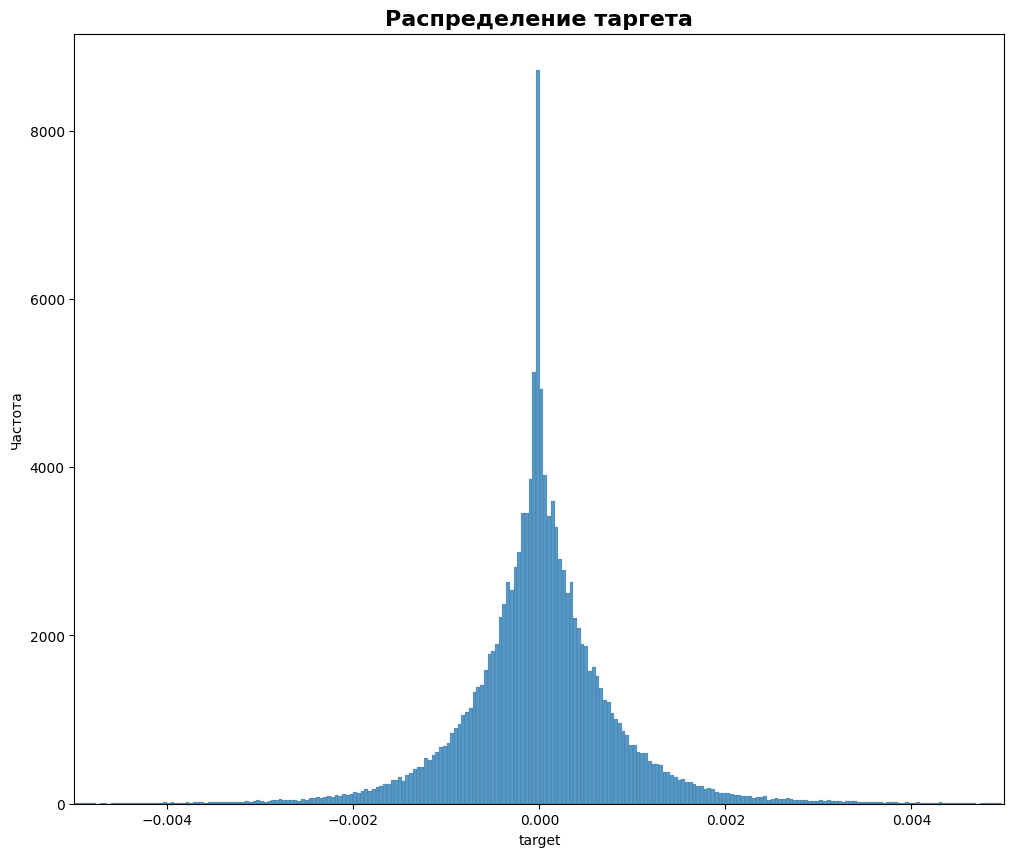

In [26]:
plt.figure(figsize=(12,10))
sns.histplot(data = X, x = 'target', bins = 1000)
plt.title('Распределение таргета', fontsize = 16, fontweight = 'bold')
plt.xlabel('target')
plt.ylabel('Частота')
plt.xlim(-0.005, 0.005)

# Вывод
Распределение переменной похоже на нормальное распределение. Центр распределения находится в точке 0. Это выглядит вполне логичным, учитывая краткосрочный характер исследуемого периода. В таком коротком временном промежутке акции обычно не подвержены значительным колебаниям, что подтверждает наблюдаемое распределение.

Text(0.5, 1.0, 'Распределение таргета в зависимости от тренда текущих 4 свеч')

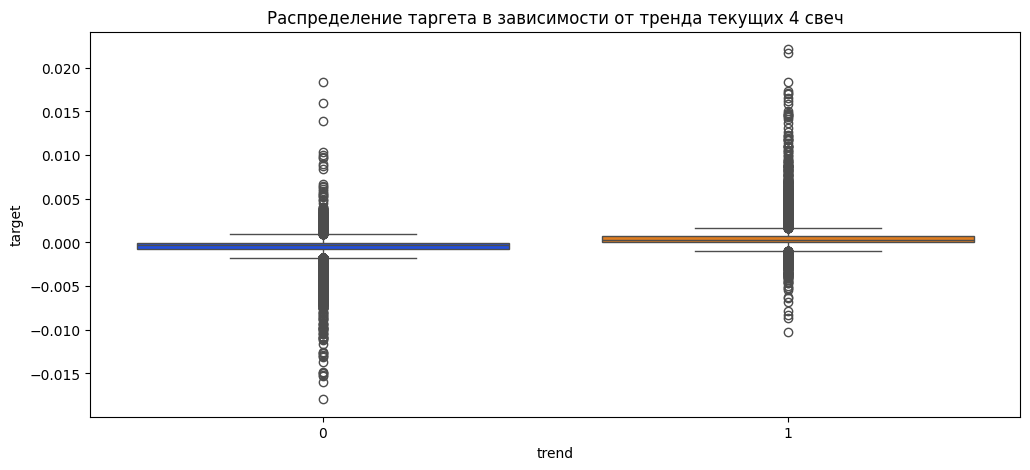

In [27]:
plt.figure(figsize=(12, 5))
plt.title("", fontsize=14, fontweight='bold')
plt.ylabel("target")
sns.boxplot(data=X, x='trend', y='target', palette = "bright")
plt.title('Распределение таргета в зависимости от тренда текущих 4 свеч')

# Вывод
Мы видим два довольно схожих "ящика с усами", но отличия все же есть
1) IQR достаточно низкий, поэтому можно видеть много выбросов, относительно межквартильного размаха 
2) Если мы говорим о положительном тренде, то на графике не отмечается роста после "сильного" (относительно наших данных и имеющегося IQR) падения. 
Обратное можно сказать и про отрицательный тренда, которые практически не несет за собо сравнительно сильного положительного отклонения, но в то же время были некоторые выбросы. 

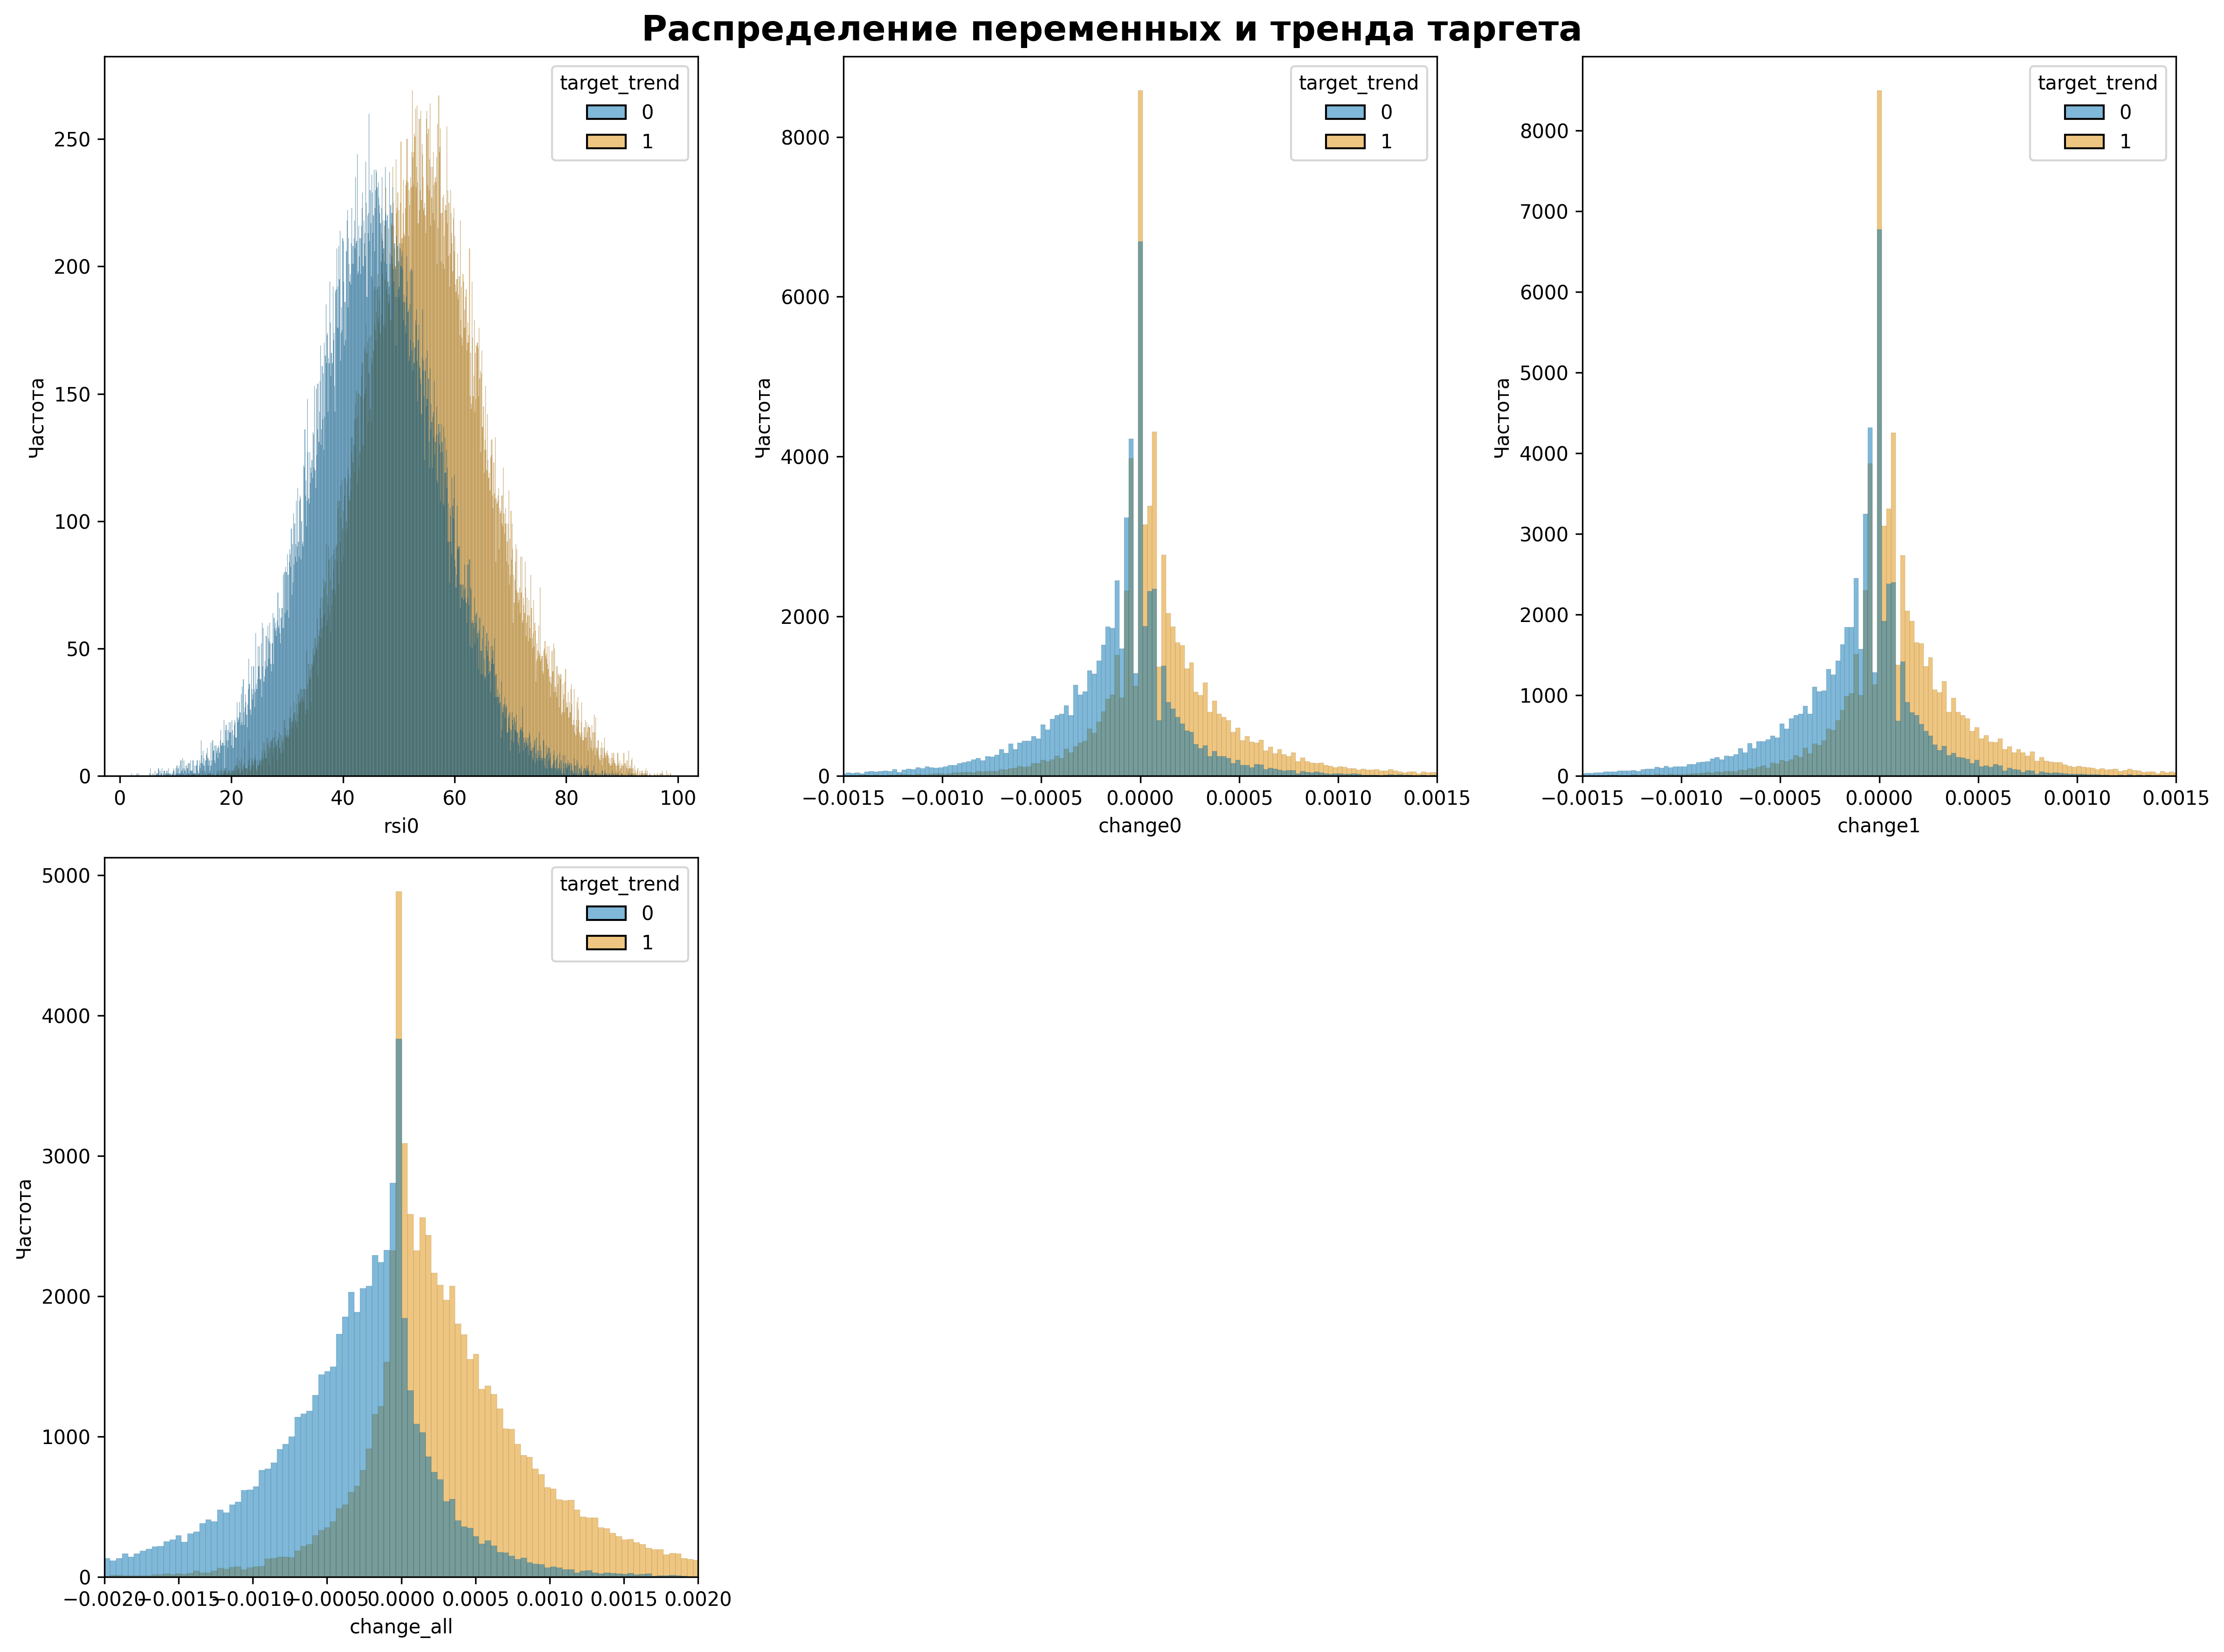

In [28]:
fig, axs = plt.subplots(2, 3, figsize=(16, 12), dpi=300)

var = ['rsi0', 'change0', 'change1', 'change_all']

for i, var in enumerate(var):
    row = i // 3
    col = i % 3 
    sns.histplot(data=X, x = var, hue = "target_trend", bins = 1000, palette = "colorblind", ax=axs[row, col])
    axs[row, col].set_ylabel("Частота")  
    axs[row, col].set_xlabel(var)  
    
fig.delaxes(axs[1, 2])
fig.delaxes(axs[1, 1])
axs[0, 1].set_xlim(-0.0015, 0.0015)
axs[0, 2].set_xlim(-0.0015, 0.0015)
axs[1, 0].set_xlim(-0.002, 0.002)

fig.suptitle('Распределение переменных и тренда таргета', fontsize = 18, fontweight = 'bold')
plt.tight_layout()  
plt.show()  

# Вывод
### RSI0
Из этого графика видна взаимосвязь RSI и значний перемнной таргета. Ценна чаще всего снижается, когда видно значние RSI около 40. А самый частый совокупный рост наблюдается при значених около 60

### Change0 и Change1
Тренд является восходящим чаще при положительном процентом изменении. И схожая ситуация с низходящим трендом: чаще при отрицательных процентных изменениях. 

Также отмечу, что при боковике (ситуация отсутствия волатильности) рынок склонен скорее рости чем падать, что видно по самому высокому "желтому столбику" в нуле по "X"

### Change_all
Если смотреть на совокупное изменнеию предыдуших свечей и предсказывать последующее изменение, то видна большая взаимосвязь нежели в предыдущем пункте. То есть рынок скорее продолжит расти, если ряд, а не только одна свечка давала рост. Также и с падением рынка. Это качество можно сравнить с инертностью.

При отсутствии роста в прошлом рынок скорее начнет расти, нежели падать

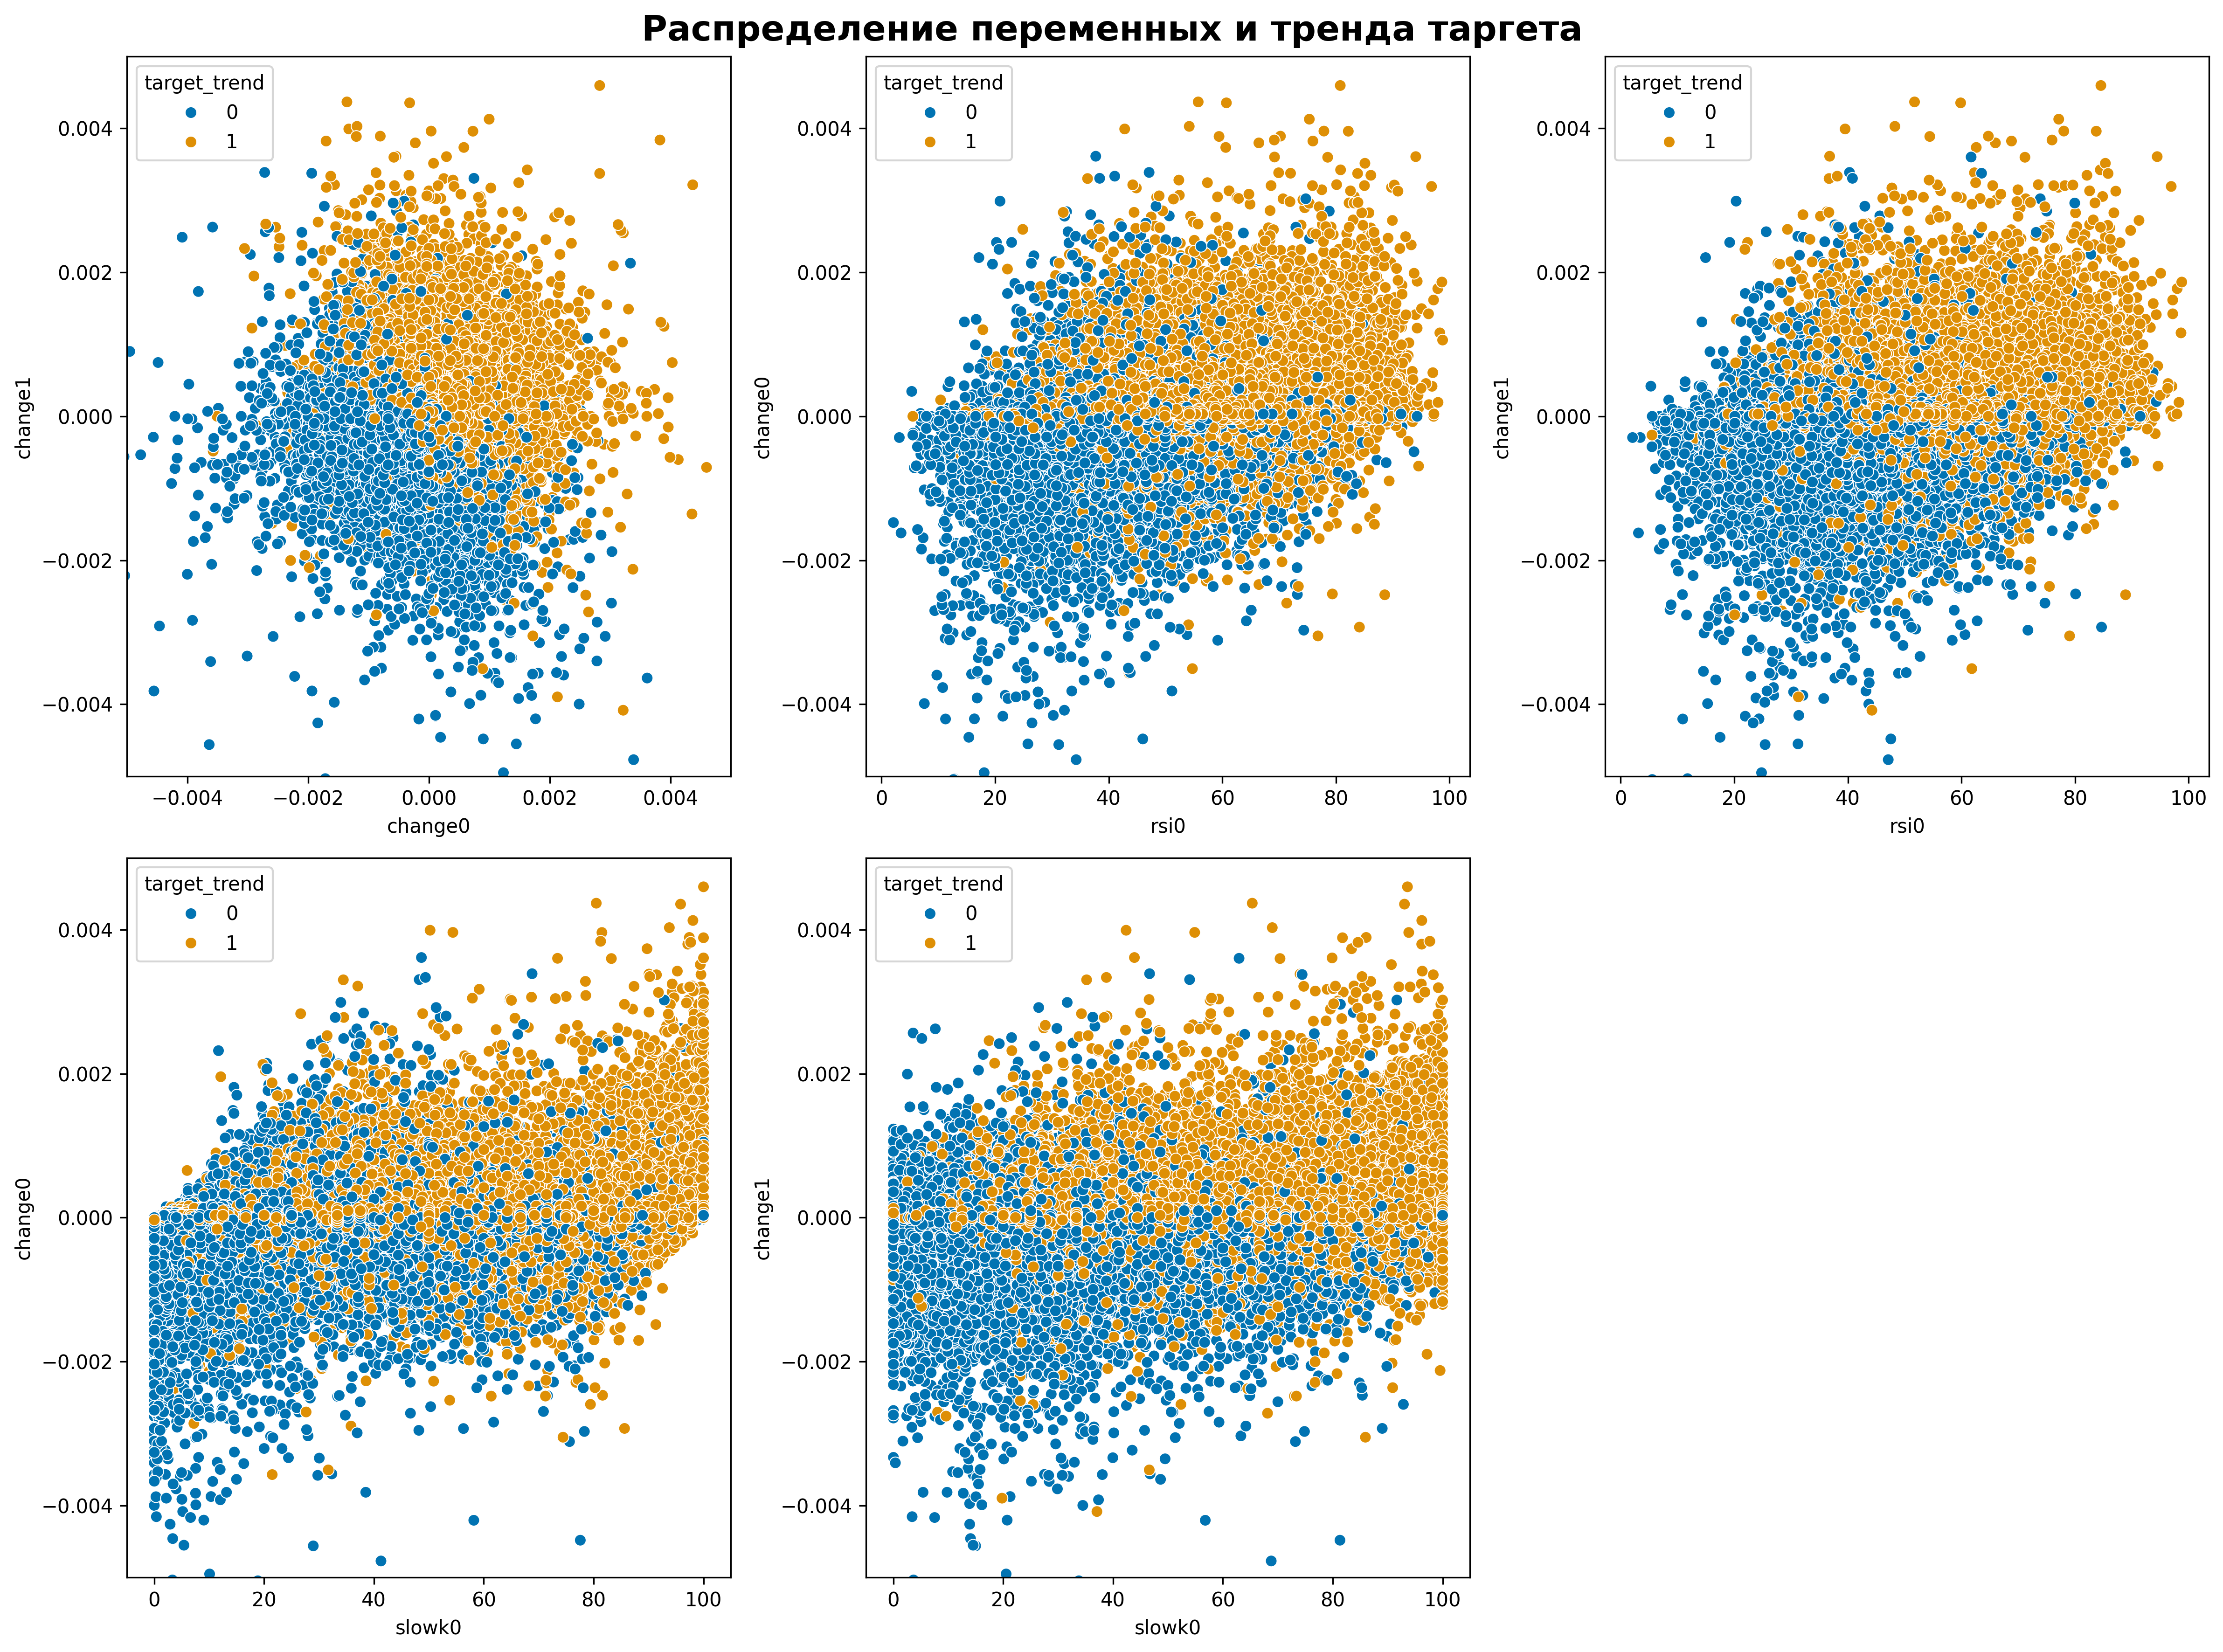

In [29]:
fig, axs = plt.subplots(2, 3, figsize=(16, 12), dpi=300)

sns.scatterplot(data=X, x = 'change0', y = 'change1', hue = "target_trend", palette = "colorblind", ax=axs[0, 0])
    
sns.scatterplot(data=X, x = 'rsi0', y = 'change0', hue = "target_trend", palette = "colorblind", ax=axs[0, 1])
sns.scatterplot(data=X, x = 'rsi0', y = 'change1', hue = "target_trend", palette = "colorblind", ax=axs[0, 2])
sns.scatterplot(data=X, x = 'slowk0', y = 'change0', hue = "target_trend", palette = "colorblind", ax=axs[1, 0])
sns.scatterplot(data=X, x = 'slowk0', y = 'change1', hue = "target_trend", palette = "colorblind", ax=axs[1, 1])
fig.delaxes(axs[1, 2])
axs[0, 0].set_xlim(-0.005, 0.005)
axs[0, 0].set_ylim(-0.005, 0.005)
axs[0, 1].set_ylim(-0.005, 0.005)
axs[0, 2].set_ylim(-0.005, 0.005)
axs[1, 0].set_ylim(-0.005, 0.005)
axs[1, 1].set_ylim(-0.005, 0.005)

fig.suptitle('Распределение переменных и тренда таргета', fontsize = 18, fontweight = 'bold')
plt.tight_layout()  
plt.show()  

# Вывод

## change0, change1
На графике мы видим, что target_trend=1 наиболее плотно отображается в точках, где и change0 и change1 положительны

С target_trend=0 наблюдается обратный факт: наибольшая плотность при отрицательных change0 и change1

Но прямая корреляция между таргетом и переменными не наблюдается, потому что выводы работают только для умернных значений, а не экстримальных отклонений котировок

## rsi0, change1
Этот график показывает, что снижению свечи предшествует низкий rsi0 и отрицательное изменение котировок. Обратное верно для роста свечи.
Но прямая корреляция между таргетом и переменными не наблюдается, потому что выводы работают только для умернных значений, а не экстримальных отклонений котировок

## rsi0, change1
Данная корреляция не сильно отличается от предыдущей ситуации, подтверждая выводы, сделанные на основе прошлого scatter графика

## slowk1, change0
На данном графике видна большАя плотность случаев положительного роста таргета при больших значениях chang0 и slowk0, поэтому можно сказать, что зависимость практически сходится в точку с умеренным ростом предшествующей свечи и максимальным значеним стохастика. 

Для снижения таргета (target_trend=0) верно, что самое большая плотность данных случаев реализуется при минимальном стохастике и умеренном снижении предшествующей свечи

## slowk1, change0
Если рассматривать данный график, основываясь рассуждениях выше, то можно сделать такие же выводы только с корректировкой на то, что связь не столь сильная, потому что взята не предыдущая свеча, а пред-предыдущая. То есть самой результативным по выявлению корреляции является предыдущий график, который можно подкреплять нынешним для предсказывания движения свечи


In [30]:
def predict(df: pd.DataFrame):
    predictions = []
    for index, row in df.iterrows():
        if -row['change0'] <= row['change1']:
            predictions.append(1)      
        else:
            predictions.append(0)
             
    return np.array(predictions)    

def accuracy_score(y_true, y_pred) -> float:
    y_true = np.asarray(y_true).reshape(-1, 1)
    y_pred = np.asarray(y_pred).reshape(-1, 1)
    return (y_true == y_pred).mean()

preds = predict(X)

print(f"Accuracy => {accuracy_score(X['target_trend'], preds)}")


Accuracy => 0.7453435852505325


In [50]:
X.columns

Index(['value0', 'Volume0', 'body0', 'colour0', 'weekday0', 'change0',
       'span_up0', 'span_down0', 'rsi0', 'macdhist0', 'slowk0', 'slowd0',
       'adx0', 'atr0', 'engulfing0', 'doji0', 'hammer0', 'inv_hammer0',
       'shooting_star0', 'marubuzu0', 'value1', 'Volume1', 'body1', 'colour1',
       'weekday1', 'change1', 'span_up1', 'span_down1', 'rsi1', 'macdhist1',
       'slowk1', 'slowd1', 'adx1', 'atr1', 'engulfing1', 'doji1', 'hammer1',
       'inv_hammer1', 'shooting_star1', 'marubuzu1', 'value2', 'Volume2',
       'body2', 'colour2', 'weekday2', 'change2', 'span_up2', 'span_down2',
       'rsi2', 'macdhist2', 'slowk2', 'slowd2', 'adx2', 'atr2', 'engulfing2',
       'doji2', 'hammer2', 'inv_hammer2', 'shooting_star2', 'marubuzu2',
       'value3', 'Volume3', 'body3', 'colour3', 'weekday3', 'change3',
       'span_up3', 'span_down3', 'rsi3', 'macdhist3', 'slowk3', 'slowd3',
       'adx3', 'atr3', 'engulfing3', 'doji3', 'hammer3', 'inv_hammer3',
       'shooting_star3', 'marubu

In [51]:
X[['engulfing0', 'doji0', 'hammer0', 'inv_hammer0', 'shooting_star0', 'marubuzu0']]

engulfing0  doji0  hammer0  inv_hammer0  shooting_star0  \
begin                                                                          
2023-05-12 10:36:00         0.0    0.0      0.0          0.0             0.0   
2023-05-12 10:37:00         0.0    0.0      0.0          0.0             0.0   
2023-05-12 10:38:00         0.0    0.0      0.0          0.0             0.0   
2023-05-12 10:39:00         0.0    0.0      0.0          0.0             0.0   
2023-05-12 10:40:00         0.0    0.0      0.0          0.0             0.0   
...                         ...    ...      ...          ...             ...   
2024-05-10 18:34:00         0.0    0.0      0.0          0.0             0.0   
2024-05-10 18:35:00         1.0    0.0      0.0          0.0             0.0   
2024-05-10 18:36:00         0.0    0.0      0.0          0.0             0.0   
2024-05-10 18:37:00         0.0    0.0      0.0          0.0             0.0   
2024-05-10 18:38:00         0.0    0.0      0.0          0.0             0.0   

                     marubuzu0  
begin                           
2023-05-12 10:36:00        0.0  
2023-05-12 10:37:00        0.0  
2023-05-12 10:38:00        0.0  
2023-05-12 10:39:00        0.0  
2023-05-12 10:40:00        0.0  
...                        ...  
2024-05-10 18:34:00        0.0  
2024-05-10 18:35:00        0.0  
2024-05-10 18:36:00        0.0  
2024-05-10 18:37:00        0.0  
2024-05-10 18:38:00        1.0  

[132398 rows x 6 columns]

In [31]:
X[['change0', 'change1', 'change2', 'change3' , 'target', 'target_trend']]

change0   change1   change2   change3    target  \
begin                                                                   
2023-05-12 10:36:00 -0.000349  0.000044  0.000699 -0.000175  0.000525   
2023-05-12 10:37:00  0.000087 -0.000349  0.000044  0.000699  0.001136   
2023-05-12 10:38:00  0.001311  0.000087 -0.000349  0.000044  0.000218   
2023-05-12 10:39:00 -0.000873  0.001311  0.000087 -0.000349 -0.002709   
2023-05-12 10:40:00 -0.003232 -0.000873  0.001311  0.000087 -0.000306   
...                       ...       ...       ...       ...       ...   
2024-05-10 18:34:00 -0.000128  0.000032  0.000416 -0.000160  0.000448   
2024-05-10 18:35:00  0.000192 -0.000128  0.000032  0.000416 -0.000224   
2024-05-10 18:36:00 -0.000192  0.000192 -0.000128  0.000032 -0.000128   
2024-05-10 18:37:00  0.000224 -0.000192  0.000192 -0.000128  0.000192   
2024-05-10 18:38:00  0.000320  0.000224 -0.000192  0.000192  0.000128   

                     target_trend  
begin                              
2023-05-12 10:36:00             1  
2023-05-12 10:37:00             1  
2023-05-12 10:38:00             1  
2023-05-12 10:39:00             0  
2023-05-12 10:40:00             0  
...                           ...  
2024-05-10 18:34:00             1  
2024-05-10 18:35:00             0  
2024-05-10 18:36:00             0  
2024-05-10 18:37:00             1  
2024-05-10 18:38:00             1  

[132398 rows x 6 columns]

(-0.005, 0.005)

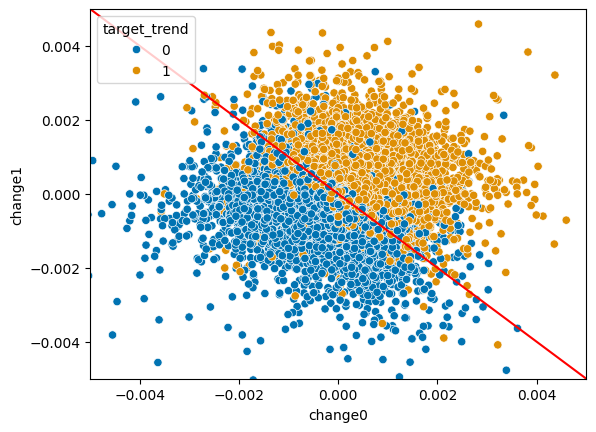

In [32]:
sns.scatterplot(data=X, x = 'change0', y = 'change1', hue = "target_trend", palette = "colorblind")
plt.plot([-0.01, 0.01], [0.01, -0.01], color='red')  # Например, красного цвета
plt.xlim(-0.005, 0.005)
plt.ylim(-0.005, 0.005)

# Вывод

Видно, что значения кучкуются, поэтому линейной взаимосвязи на ВСЕМ (а не часте) промежутке отразить не получится

Также отметим, что нисходящая свеча может наблюдаться и в случае положительного изменения "0" свечи, но при этом значения "1" свечи должны быть ниже обычного. Если в терминах штрафов, то положительный значения change0 штрафуются более низкими значениями change1, если рассматриваем отрицательный таргет. Поэтому на часте графика видна отрицательная взаимосвязь между change0 и change1

Зеркальная логика применима и к положительному таргету, выводы об отрицательной взаимосвязи валидны и в данном случае

# Гипотезы
1. Предсказания, основанные на всех параметрах будет склонно к переобучению. Нужно будет отбросить некоторые параметры
2. На основании изменения предыдущих 4 свеч ('change_all'), можно предсказывать изменение инструмента в краткосрочном периоде.
3. Предсказывать рост/падение акций можно на основании опережающих осцилляторв Stochastic и RSI. Вывлены сильные корреляции target_trend с change0, rsi0, slowk0
4. На основании объёмов торгов в связке со свечным паттерном можно сказать, что многие инвесторы заметили паттерн, и цена скорее будет двигаться в сторону паттерна.


# Задачи
1. Предскажем как просто направленности свечи, так и ее величину. В каких-то ситуациях важен тренд, а не конкретное изменение, поэтому предсказания в виде 0 или 1 тоже будет полезно и скорее всего более точным, нежели точное изменение 
2. Обучение будем проводить на основании линейной регрессии, линейной классификации и логистической регресии.

# Машинное обучение

Разделим данные на признаки и целевую переменную

In [111]:
# Нужные пакеты
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

In [102]:
X_lr = X.drop(columns=['target', 'target_trend'])
y = X['target']

Для начала закодируем катеориальные признаки, используя OHE

In [103]:
categorical_features = [col for col in X.columns if 'weekday' in col or 'colour' in col]

X_lr = X.drop(columns=['target', 'target_trend'])
y = X['target']

X_lr = pd.get_dummies(X_lr, columns=categorical_features)

Проведём теперь предобработку данных для машинного обучения, разделим выборку на тренировочную и тестовую, затем проведём нормализацию данных для того, чтобы признаки по равному влияли на вывод модели.
Мы решили использовать именно MinMaxScaler, потому что он сохраняет распределение данных, а только переводит данные в заданный диапазон.

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X_lr, y, test_size=0.2, random_state=42)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Перейдём теперь к самому интересному - машинному обучению, для начала обучим обычную модель линейной регрессии и оценим её результаты.

In [105]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

y_pred_train=lr.predict(X_train_scaled)
y_pred = lr.predict(X_test_scaled)

Обучив, обычную линейную модель мы решили использовать,метрики качества такие как MAE,MSE и R2. \
MAE и MSE - дают представление о точности предсказаний модели, но с разным акцентом. MAE показывает среднюю ошибку, а MSE выделяет крупные ошибки, что позволяет получить более полное представление о поведении модели. \
R²-коэффициент детерминации показывает, насколько хорошо модель объясняет дисперсию целевой переменной, что полезно для общей оценки качества модели. \
MAPE мы решили не использовать, поскольку иногда у нас бывает, что целевая перменная равно 0 и из-за этого MAPE мог бы получаться слишком огромным и нерепрезентативным.

In [106]:
mse = mean_squared_error(y_train, y_pred_train)
mae = mean_absolute_error(y_train, y_pred_train)
r2 = r2_score(y_train, y_pred_train)
mape=mean_absolute_percentage_error(y_train,y_pred_train)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R2",r2)

Mean Squared Error (MSE): 2.398452151717339e-07
Mean Absolute Error (MAE): 0.0002779115913597876
R2 0.7342666925858948


На тренировочных данных достаточно хорошие получились результаты, однако гораздо важнее проверить модель на тестовых данных.

In [107]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape=mean_absolute_percentage_error(y_test,y_pred)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R2",r2)

Mean Squared Error (MSE): 2.5933575040877824e-07
Mean Absolute Error (MAE): 0.00028181756538998317
R2 0.7303753643522173


Маленькие значения MSE и MAE указывают на высокую точность модели, однако стоит понимать, что MSE такой низкий не из-за того, что модель предсказывает небольшие величины и если возвести дробь в квадрат, то дробь станет ещё меньше. \
Высокое значение R² (0.73) указывает на то, что модель объясняет значительную часть вариации в данных. В контексте предсказания изменений стоимости акций, где данные могут быть очень шумными и сложными для предсказания, это хороший результат.

Попробуем теперь провести регуляризацию L1 с использованием Лассо. Лассо полезен особенно для нашей модели, у нас поскольку множество признаков,Лассо поможет отобрать признаки, уменьшая некоторые коэффициенты до нуля. Лассо добавляет штраф за абсолютное значение коэффициентов, что приводит к тому, что незначимые признаки могут быть исключены из модели. Это помогает улучшить обобщающую способность модели и уменьшить переобучение.

In [108]:
from sklearn.linear_model import LassoCV
lasso_cv = LassoCV(cv=5, random_state=42)
lasso_cv.fit(X_train_scaled, y_train)

best_alpha = lasso_cv.alpha_

lasso = Lasso(alpha=best_alpha)
lasso.fit(X_train_scaled, y_train)

y_pred = lasso.predict(X_test_scaled)

mse_lasso_cv = mean_squared_error(y_test, y_pred)
mae_lasso_cv = mean_absolute_error(y_test, y_pred)
r2_lasso_cv = r2_score(y_test, y_pred)
mape_lasso_cv = mean_absolute_percentage_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse_lasso_cv)
print("Mean Absolute Error (MAE):", mae_lasso_cv)
print("R2:", r2_lasso_cv)

Mean Squared Error (MSE): 2.81693546112782e-07
Mean Absolute Error (MAE): 0.0002873343370107747
R2: 0.7071305455754864


Качество модели слегка упало, видимо из-за специфики, Лассо регуляризации некоторые коэффициент стали равны 0, из-за чего модель потеряли некоторые важные взаимосвязи модели и качество ухудшилосью

Интересно построить модель на схожести свечей с другими, поскольку явно то, что было в прошлом могло повториться в будущем и быть может это поможет нам делать более точные прогнозы. Возможно,другой метод машинного обучения KNN будет эффективно использовать исторические данные для предсказания будущих значений, основываясь на схожести текущих условий с прошлыми.

In [112]:
from sklearn.neighbors import KNeighborsRegressor
k_range = range(1, 10)
k_scores = []

for k in k_range:
    knn = KNeighborsRegressor(n_neighbors=k)
    scores = cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
    k_scores.append(scores.mean())

optimal_k = k_range[np.argmax(k_scores)]
print(f"Optimal value of k: {optimal_k}")

knn = KNeighborsRegressor(n_neighbors=optimal_k)
knn.fit(X_train_scaled, y_train)

y_pred = knn.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print("KNN Regression:")
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R²):", r2)

Optimal value of k: 9
KNN Regression:
Mean Squared Error (MSE): 5.671720326635939e-07
Mean Absolute Error (MAE): 0.00044100121355314435
R-squared (R²): 0.4103259870053092


# LogReg для CRS
CRS - Change0, Rsi0, Slowk0

Некторые пункты в объяснении будут пропущены, так как трактовка схожих строк кода была выше

Теперь оценим не точное измение свечи, а ее направление. Предсказывать будем через логистическую регрессию. 

In [113]:
X_CRS = X[['change0', 'rsi0', 'slowk0']]

scaler = MinMaxScaler()
X_CRS_scaled = scaler.fit_transform(X_CRS)
y_CRS = X['target_trend']

LogReg = LogisticRegression()
X_train, X_test,  y_train, y_test = train_test_split(X_CRS_scaled, y_CRS, test_size=0.2, random_state=34)
LogReg.fit(X_train, y_train)
y_predict = LogReg.predict(X_test)

mse = mean_squared_error(y_predict, y_test)
precision = precision_score(y_predict, y_test)
recall = recall_score(y_predict, y_test)

print('mse=', mse)
print("Precision:", precision)
print("Recall:", recall)

mse= 0.29977341389728096
Precision: 0.72829674271775
Recall: 0.70976087260523


Предсказания с ограниченным количеством параметров, которые были выбраны, исходя из графиков и интерпретаций выше, достаточно хороши, но нужно проверить предсказания и со всей имеющейся информацией

# LogReg для all
all - all columns execpt of ['target', 'target_trend']


In [114]:

categorical_features = [col for col in X.columns if 'weekday' in col or 'colour' in col]

X_all = X.drop(columns=['target', 'target_trend'])
y = X['target']

X_all = pd.get_dummies(X_all, columns=categorical_features)

scaler = MinMaxScaler()
X_all_scaled = scaler.fit_transform(X_all)
y_all = X['target_trend']

LogReg = LogisticRegression()
X_train, X_test,  y_train, y_test = train_test_split(X_all_scaled, y_all, test_size=0.2, random_state=34)
LogReg.fit(X_train, y_train)
y_predict = LogReg.predict(X_test)

mse = mean_squared_error(y_predict, y_test)
precision = precision_score(y_predict, y_test)
recall = recall_score(y_predict, y_test)

print('mse=', mse)
print("Precision:", precision)
print("Recall:", recall)


mse= 0.16975075528700906
Precision: 0.8439517864829962
Recall: 0.8352623730739189


Как мы видим предсказания на модели с большим количеством параметров происходят лучше, что вполне ожидаемо.